# Data in Wild! Camera Traps


The goal of this notebook is to

1. Show how to download and interact with the datasets package on huggingface, a common place to find data.
2. Generate a tiny dataset from the very large original dataset.
3. Download images from a cloud bucket
4. Create a pytorch dataset, dataloader and pythorch-lightning model
5. Run a basic training loop.

## Download annotations

Generating train split: 104780 examples [00:08, 12329.61 examples/s]


Created dataframe with shape: (64974, 3)

First few rows:
           filename                                              image  \
0  A01/01100085.JPG  https://lilablobssc.blob.core.windows.net/orin...   
1  A01/01100087.JPG  https://lilablobssc.blob.core.windows.net/orin...   
2  A01/01140091.JPG  https://lilablobssc.blob.core.windows.net/orin...   
3  A01/01140092.JPG  https://lilablobssc.blob.core.windows.net/orin...   
4  A01/01140093.JPG  https://lilablobssc.blob.core.windows.net/orin...   

                 species  
0  dasyprocta fuliginosa  
1  dasyprocta fuliginosa  
2          pecari tajacu  
3          pecari tajacu  
4          pecari tajacu  


<Axes: xlabel='species'>

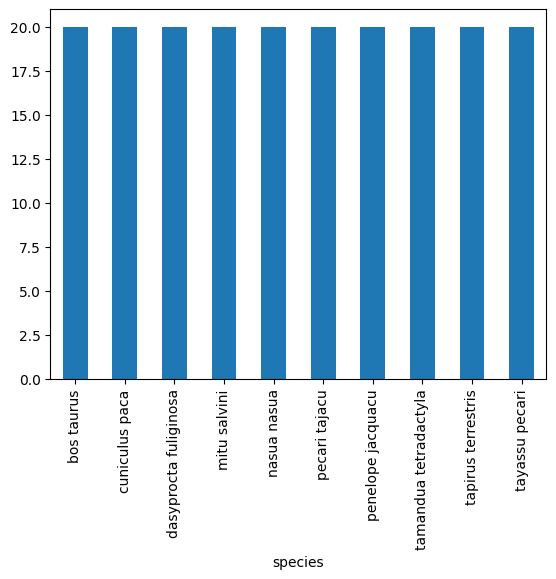

In [4]:
import pandas as pd
from datasets import load_dataset

# Load dataset
dataset = load_dataset("society-ethics/lila_camera_traps", "Orinoquia Camera Traps", split="train", trust_remote_code=True)
taxonomy = dataset.features["annotations"].feature["taxonomy"]

# Create empty lists to store data
filenames = []
species = []
images = []

# Extract filename and species for non-empty annotations
for example in dataset:
    species_id = example["annotations"]["taxonomy"][0]["species"]
    if species_id is not None:
        images.append(example["image"])
        filenames.append(example["file_name"])
        species_name = taxonomy["species"].int2str(species_id)
        species.append(species_name)

# Create dataframe
df = pd.DataFrame({
    'filename': filenames,
    'image': images,
    'species': species
})

print("Created dataframe with shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# select the 20 images from the top 10 species
df = df[df['species'].isin(df['species'].value_counts().head(10).index)]
df = df.groupby('species').sample(20)

# Plot
df.groupby('species').size().plot(kind='bar')


## Download images

In [5]:
from PIL import Image, ImageDraw
import requests
from io import BytesIO
import os
from tqdm import tqdm

def download_images(df, output_dir="images"):
    os.makedirs(output_dir, exist_ok=True)
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Downloading images"):
        filename = row['filename']
        output_path = os.path.join(output_dir, filename)
        # Recursively make directories
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        if os.path.exists(output_path):
            continue
            
        try:
            response = requests.get(row['image'].replace("https://lilablobssc.blob.core.windows.net","https://lilawildlife.blob.core.windows.net/lila-wildlife"))
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                img.save(output_path)
            else:
                print(f"Failed to download {filename}: Status code {response.status_code}")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")

download_images(df)

## Create a train/test split

### Key Terminology

In the pytorch universe there are three key elements, datasets, dataloaders and models.

Torch datasets are abstractions that handle data loading and preprocessing. They are typically subclasses of `torch.utils.data.Dataset` and define two main methods: `__len__` (returns the size of the dataset) and `__getitem__` (retrieves a data sample).

Dataloaders, implemented via `torch.utils.data.DataLoader`, provide an iterable over a dataset, enabling efficient batching, shuffling, and parallel data loading.

Models in PyTorch are defined as subclasses of `torch.nn.Module`. They encapsulate layers and define the forward pass of the network.

PyTorch Lightning modules integrate these components by organizing the training, validation, and testing logic. A `LightningModule` defines methods like `training_step`, `validation_step`, and `test_step`, and connects datasets, dataloaders, and models into a cohesive workflow. This abstraction simplifies training loops and enables seamless integration with hardware accelerators.

In [6]:
from sklearn.model_selection import train_test_split

# Train test split
# Filter out classes with less than 5 images
class_counts = df["species"].value_counts()
valid_classes = class_counts[class_counts >= 5].index
filtered_annotations = df[df["species"].isin(valid_classes)]

# Split images into train and test sets
train_images = []
test_images = []

for common_name in valid_classes:
    class_images = filtered_annotations[filtered_annotations["species"] == common_name]["filename"].tolist()
    if len(class_images) > 5:
        train, test = train_test_split(class_images, test_size=5, random_state=42)
        train_images.extend(train)
        test_images.extend(test)

print("valid_classes: ", valid_classes)
print("Number of train images: ", len(train_images))
print("Number of test images: ", len(test_images))

valid_classes:  Index(['bos taurus', 'cuniculus paca', 'dasyprocta fuliginosa', 'mitu salvini',
       'nasua nasua', 'pecari tajacu', 'penelope jacquacu',
       'tamandua tetradactyla', 'tapirus terrestris', 'tayassu pecari'],
      dtype='object', name='species')
Number of train images:  150
Number of test images:  50


## Create a torch dataset

In [19]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class WildlifeDataset(Dataset):
    def __init__(self, image_paths, annotations, transform=None):
        self.image_paths = image_paths
        self.annotations = annotations
        self.transform = transform
        classes = annotations['species'].unique()
        self.string_to_label = {label: i for i, label in enumerate(classes)}


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join("images", self.image_paths[idx])
        str_label = self.annotations.loc[self.annotations['filename'] == self.image_paths[idx], 'species'].values[0]
        label = self.string_to_label[str_label]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Numpy array, channels first
        image = np.array(image).transpose(2, 0, 1).astype(np.float32)
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Example usage
train_dataset = WildlifeDataset(train_images, filtered_annotations)
test_dataset = WildlifeDataset(test_images, filtered_annotations)

# Show example
image, label = train_dataset[0]
print("Image shape: ", image.shape)
print("Label: ", label)

Image shape:  (3, 1440, 1920)
Label:  0


## Create a torch dataloader

In [20]:
from torch.utils.data import DataLoader

# Dataloader

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Example: Iterate through the train_loader
for images, labels in train_loader:
    print(f"Batch size: {len(images)}")
    break

Batch size: 2


## Create a classification model

## Terminología Clave de un Módulo de PyTorch Lightning

### Terminología Clave
1. **Datasets**: Abstracciones que manejan la carga y preprocesamiento de datos. Son subclases de `torch.utils.data.Dataset` y definen dos métodos principales: `__len__` (devuelve el tamaño del conjunto de datos) y `__getitem__` (recupera una muestra de datos).

2. **Dataloaders**: Implementados mediante `torch.utils.data.DataLoader`, proporcionan un iterable sobre un conjunto de datos, permitiendo un batching eficiente, mezcla de datos y carga paralela.

3. **Models**: Definidos como subclases de `torch.nn.Module`. Encapsulan capas y definen el paso hacia adelante (forward pass) de la red.

4. **LightningModule**: Un módulo de PyTorch Lightning que organiza la lógica de entrenamiento, validación y prueba. Define métodos como `training_step`, `validation_step` y `test_step`, conectando datasets, dataloaders y modelos en un flujo de trabajo cohesivo. Esta abstracción simplifica los bucles de entrenamiento y permite una integración fluida con aceleradores de hardware.



In [26]:
import pytorch_lightning as pl
from torch import nn

import torchvision.models as models
import torch.optim as optim
from torchmetrics import Accuracy

class ResNetClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.model = models.resnet18(pretrained=True)
        
        # Replace the final fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, labels)
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Instantiate the model
model = ResNetClassifier(num_classes=len(df["species"].unique()))

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10)

# Fit the model
trainer.fit(model, train_dataloaders =train_loader)

/blue/ewhite/b.weinstein/miniconda3/envs/megadetector/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/blue/ewhite/b.weinstein/miniconda3/envs/megadetector/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/blue/ewhite/b.weinstein/miniconda3/envs/megadetector/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun

Epoch 0:   0%|          | 0/75 [00:00<?, ?it/s] 

Epoch 9: 100%|██████████| 75/75 [00:05<00:00, 13.57it/s, v_num=6.53e+7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 75/75 [00:05<00:00, 12.59it/s, v_num=6.53e+7]


# Predict test set

In [29]:
trainer.validate(dataloaders=test_loader)

/blue/ewhite/b.weinstein/miniconda3/envs/megadetector/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /blue/ewhite/b.weinstein/miniconda3/envs/megadetecto ...
/blue/ewhite/b.weinstein/miniconda3/envs/megadetector/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/b.weinstein/AI_for_ecology_workshop/notebooks/lightning_logs/version_65324895/checkpoints/epoch=9-step=750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Validation DataLoader 0: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.1599999964237213
        val_loss             2.180530548095703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.180530548095703, 'val_acc': 0.1599999964237213}]